In [5]:
import country_converter as coco
import geopandas as gpd
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt


In [6]:
# Merge the two dataframes
# ...following Ruben's notebook...
# merged_geo_df_complete = pd.merge(left = cl_real_happiness, right = geo_df)

merged_geo_df_complete = pd.read_csv("data/merged_geo_df_complete.csv", index_col=0)

#### Preparing Data for Mapping (Price/Sq Meter)

In [7]:
price_sq_meter = merged_geo_df_complete[['city','country', 'price_per_sq_meter (city)', 'country_code', 'geometry', 'iso2_code']]
avg_price_country = price_sq_meter.groupby(['country']).mean('price_per_sq_meter (city)')
avg_price_country.rename({"price_per_sq_meter (city)":"price_per_sq_meter"}, axis = 1, inplace=True) # It's averaged out to country now 
avg_price_country

,price_per_sq_meter
country,
Afghanistan,486.063333
Albania,887.849000
Algeria,947.055789
Andorra,4390.603333
Angola,5421.610000
...,...
Venezuela,665.510000
Vietnam,1748.847778
Yemen,2786.350000


In [8]:
country_geoms = price_sq_meter[['country', 'geometry']].drop_duplicates() # need drop_duplicates because psm had country repeated for each city 
country_geoms

,country,geometry
0,United States,MULTIPOLYGON (((-122.75301682799991 48.9925145...
2793,Hungary,POLYGON ((22.877600546000053 47.94673858700013...
2820,South Korea,MULTIPOLYGON (((128.36491946700005 38.62433502...
2834,China,MULTIPOLYGON (((78.91769413200012 33.386257833...
2894,India,MULTIPOLYGON (((77.80034631400014 35.495405579...
...,...,...
5000,Congo (Kinshasa),MULTIPOLYGON (((18.626387166000086 3.476868998...
5001,Myanmar,MULTIPOLYGON (((92.57587854000013 21.977574362...
5002,Comoros,MULTIPOLYGON (((43.78874759200005 -12.30803801...
5003,Lesotho,POLYGON ((28.980845581000068 -28.9090353389999...


In [9]:
avg_price_country_geoms = pd.merge(avg_price_country, country_geoms, how="inner", on="country") 
avg_price_country_geoms.sort_values("price_per_sq_meter", ascending=False)

,country,price_per_sq_meter,geometry
123,Niger,240963.67,"POLYGON ((3.596400187000114 11.69577301000001,..."
152,Solomon Islands,85048.56,MULTIPOLYGON (((160.50367272200003 -11.7360165...
111,Monaco,82192.13,"POLYGON ((7.43745403212602 43.74336054083465, ..."
153,Somalia,67728.60,"POLYGON ((46.46696287700007 6.538292406000039,..."
27,Burundi,24307.24,POLYGON ((30.554599650000057 -2.40062754299988...
...,...,...,...
89,Kosovo,NaN,POLYGON ((20.064955688000055 42.54675811800003...
95,Lesotho,NaN,POLYGON ((28.980845581000068 -28.9090353389999...
105,Mali,NaN,POLYGON ((-12.2641304119999 14.774939067000034...
116,Myanmar,NaN,MULTIPOLYGON (((92.57587854000013 21.977574362...


Before mapping, we need to convert `avg_price_country` to a geopandas dataframe that properly recognizes the geometry data. Currently, the entries in that column are just stored as strings. We'll need to convert that column to a geopandas series first before making the geopandas dataframe.

In [10]:
avg_price_country_geoms['geometry'] = gpd.GeoSeries.from_wkt(avg_price_country_geoms['geometry'])
df = gpd.GeoDataFrame(avg_price_country_geoms, geometry='geometry')

#### Mapping Price/Sq Meter

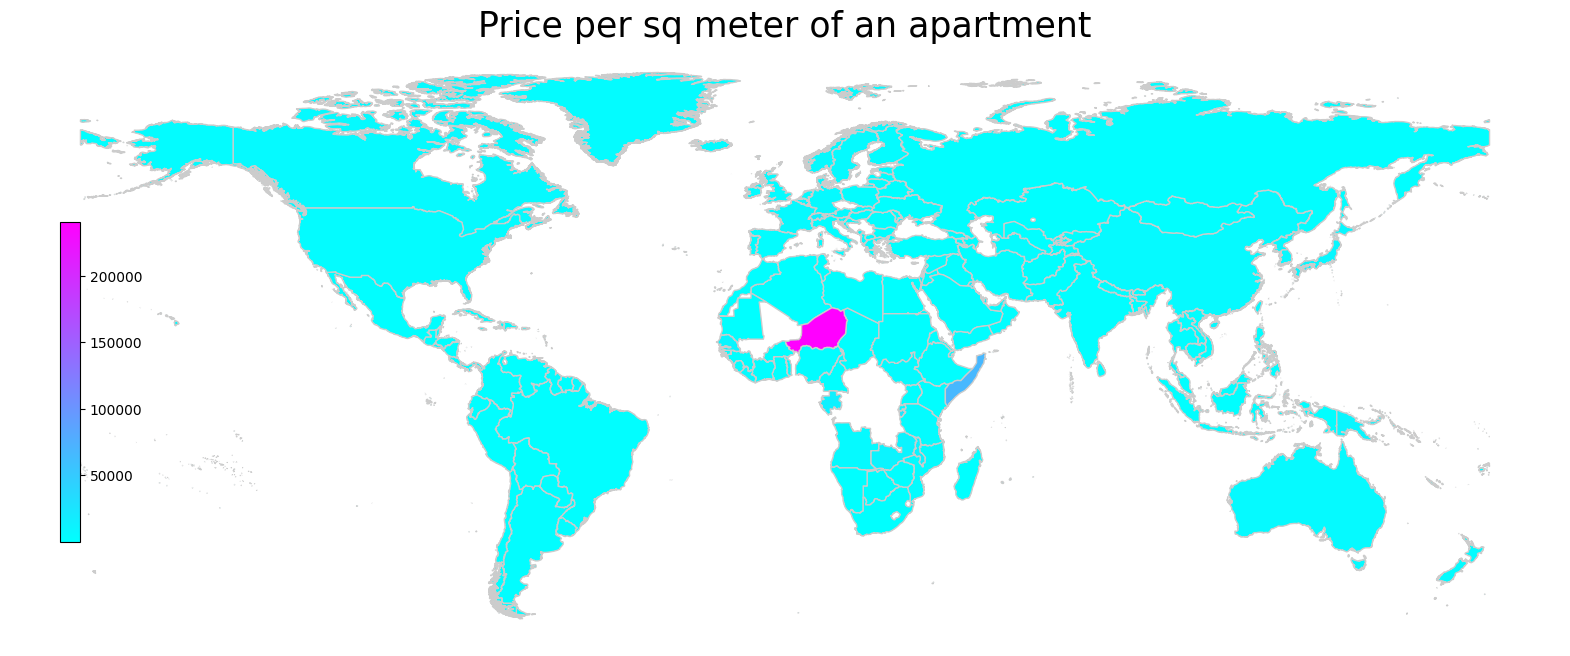

In [14]:
from geopandas import GeoDataFrame

title = 'Price per sq meter of an apartment'
source = 'Cost of Living Data Set'
col = 'price_per_sq_meter'

# source = 'Source: relataly.com \nGrowth Rate = New cases / All previous cases'
vmin = df[col].min()
vmax = df[col].max()
cmap = 'cool'

# Create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(20, 8))

# Remove the axis
ax.axis('off')
df.plot(column=col, ax=ax, edgecolor='0.8', linewidth=1, cmap=cmap)

# Add a title
ax.set_title(title, fontdict={'fontsize': '25', 'fontweight': '3'})

# Create an annotation for the data source
# ax.annotate(source, xy=(0.1, .08), xycoords='figure fraction', horizontalalignment='left', verticalalignment='bottom', fontsize=10)

# Create colorbar as a legend
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap=cmap)

# Empty array for the data range
sm._A = []

# Add the colorbar to the figure
cbaxes = fig.add_axes([0.15, 0.25, 0.01, 0.4])
cbar = fig.colorbar(sm, cax=cbaxes)

##### Things to fix about this map: 
* Numerous African Countries have  missing shapefiles
* Certain countries have erroneous data which skews the display (Niger, Somalia, and Burundi in particular)
* Setting the US to state-level would provide helpful context for Americans like ourselves

